1. 2D minimization of a six-hump camelback function

f(x,y)=((4-(-2.1*x^2)+((x^4)/3))*(x^2 ) )+(x* y )+((4*(y^2)-4)*(y^2))

has multiple global and local minima.

-Find the global minima of this function
-How many global minima are there, and what is the function value at those points?
-What happens for an initial guess of (x,y)=(0,0)?
Hints:
-Variables can be restricted to -2<x<2 and -1<y<1.
-Use numpy.meshgrid() and pylab.imshow() to graphically display the regions.
-Use scipy.optimize.minimize(), trying its optional arguments.



In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the six-hump camelback function
def six_hump_camelback(x):
    return ((4 - 2.1 * x[0]**2 + x[0]**4 / 3) * x[0]**2) + x[0] * x[1] + ((-4 + 4 * x[1]**2) * x[1]**2)

bounds = [(-2, 2), (-1, 1)]

# Optimizing over a grid of points
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = six_hump_camelback([X, Y])

Global Minima:
Minima 1: Value = -1.0316284534888052, Point = [ 0.08984221 -0.71265608]
Minima 2: Value = -1.0316284534869613, Point = [ 0.08984204 -0.71265581]
Minima 3: Value = 0.0, Point = [0. 0.]
Minima 4: Value = -1.0316284534887465, Point = [-0.08984221  0.71265607]
Minima 5: Value = -1.031628453486871, Point = [-0.08984205  0.7126558 ]
Minima 6: Value = -1.0316284534893616, Point = [-0.08984165  0.71265637]
Minima 7: Value = -1.0316284534897993, Point = [-0.08984215  0.71265638]
Minima 8: Value = -1.031628453489816, Point = [ 0.08984214 -0.71265639]
Minima 9: Value = -1.031628453489333, Point = [ 0.08984164 -0.71265638]


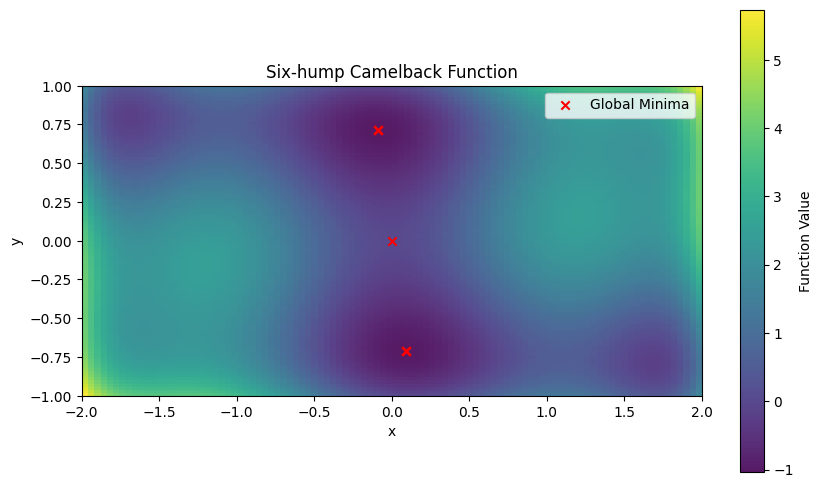

In [2]:
# Find the global minimum using scipy.optimize.minimize
initial_guesses = [(-0.5, -0.5), (0.5, -0.5), (0, 0), (0.5,0.5), (-0.5,0.5), (0.05,0.05), (-0.05,0.05), (0.05,-0.05), (-0.05,-0.05)]
global_minima = []

for guess in initial_guesses:
    result = minimize(six_hump_camelback, guess, bounds=bounds)
    global_minima.append((result.fun, result.x))

print("Global Minima:")
for i, (value, point) in enumerate(global_minima):
    print(f"Minima {i+1}: Value = {value}, Point = {point}")

plt.figure(figsize=(10, 6))
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis', alpha=0.9);plt.colorbar(label='Function Value')
plt.scatter([point[0] for _, point in global_minima], [point[1] for _, point in global_minima], color='red', marker='x', label='Global Minima')
plt.xlabel('x');plt.ylabel('y');plt.title('Six-hump Camelback Function')
plt.legend();plt.show()
# The function has six local minima, two of which are global
# The function has global minimum f (x*) = -1.0316, at x*= (0.0898,-0.7126) and (-0.0898, 0.7126).

2. Non-linear ODE: the damped pendulum

The equation of the motion of a forced pendulum, as a function of the angle θ with the vertical, is given by:

(d^2θ) / (dt^2)  = - (1/Q) * (dθ/dt) + (g/l) * sin(θ) + (d)*Ωcos@t)
 
where t is time,Q is the damping factor, d is the forcing amplitudeΩ and @ is the driving frequency of the forcing.

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable w=dθ/dt:

dt / dθ = w
dw / dt = - (1/Q) * w + (g/l) * sin(θ)Ω+ d * cos(@t)

Consider the initial conditions θ_0=w_0=0, and l=10, Q=2.0 ,d=1.5, and w=0.65.

Solve the ODE with odeint over a period of 200 time steps
Create two plots, one of θ as a function of the time, and w as a function of the time 
Optional: determine if there is a set of parameters for which the motion is chaotic.otion is chaotic.

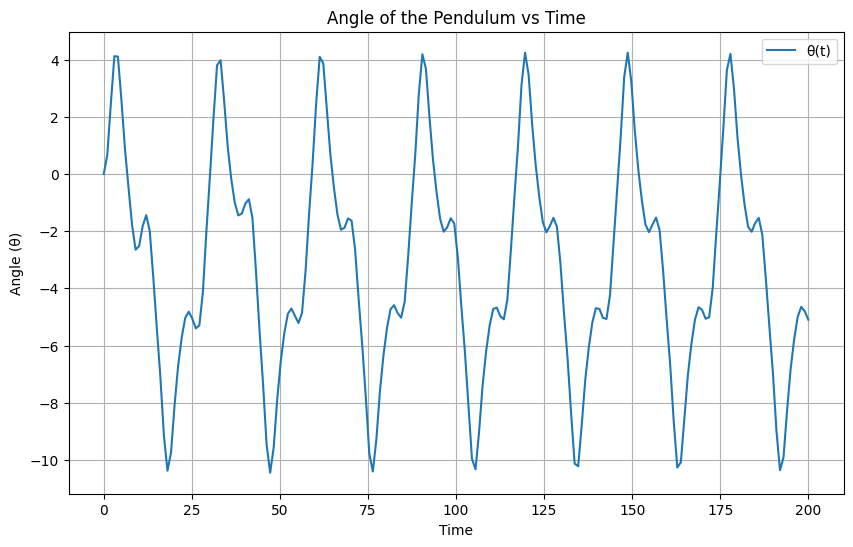

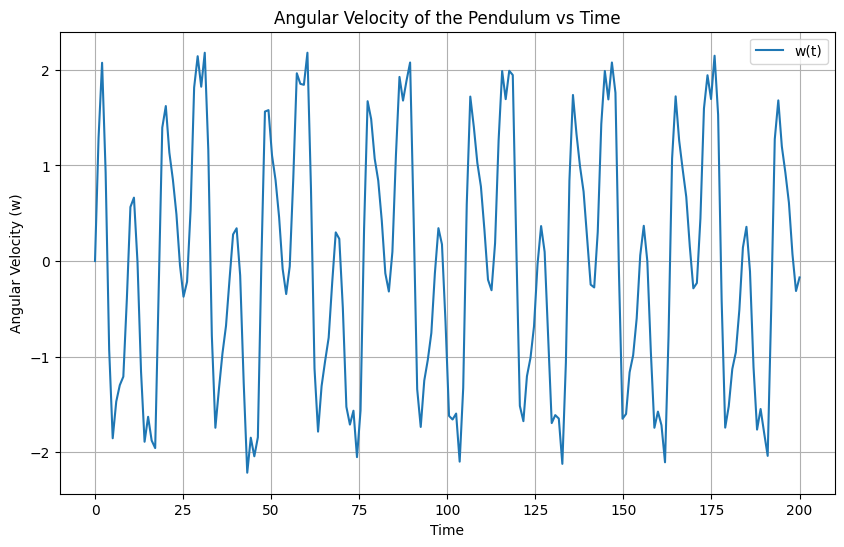

In [3]:
from scipy.integrate import odeint

# Define the system of ODEs
def pendulum_equations(y, t, Q, d, g, l, omega):
    theta, w = y
    dthetadt = w
    dwdt = -(1/Q) * w + (g/l) * np.sin(theta) + d * np.cos(omega * t)
    return [dthetadt, dwdt]

theta0 = 0;w0 = 0;initial_conditions = [theta0, w0]
Q = 2.0;d = 1.5;l = 10
g = 9.81  # Acceleration due to gravity (m/s^2)
omega = 0.65  # Frequency of the forcing

t = np.linspace(0, 200, 200)

# Solve the ODEs
solution = odeint(pendulum_equations, initial_conditions, t, args=(Q, d, g, l, omega))

theta_values = solution[:, 0]
w_values = solution[:, 1]

# Plot theta as a function of time
plt.figure(figsize=(10, 6))
plt.plot(t, theta_values, label='θ(t)')
plt.xlabel('Time');plt.ylabel('Angle (θ)');plt.title('Angle of the Pendulum vs Time')
plt.grid(True);plt.legend();plt.show()

# Plot w as a function of time
plt.figure(figsize=(10, 6))
plt.plot(t, w_values, label='w(t)')
plt.xlabel('Time');plt.ylabel('Angular Velocity (w)');plt.title('Angular Velocity of the Pendulum vs Time')
plt.grid(True);plt.legend();plt.show()


3. FFT of a simple dataset

Perform a periodicity analysis on the lynxs-hares population, i.e determine what is the period of the population of these animals.

In [4]:
# year	hare	lynx	carrot
data = np.loadtxt("populations.txt", skiprows=1)  # Skip the header row

# Extract the population data for lynxes and hares
years = data[:, 0]
lynx_population = data[:, 1]
hare_population = data[:, 2]
print(data)
print(data.shape)
print(data.dtype)
print(np.isnan(data).any())


[[ 1900. 30000.  4000. 48300.]
 [ 1901. 47200.  6100. 48200.]
 [ 1902. 70200.  9800. 41500.]
 [ 1903. 77400. 35200. 38200.]
 [ 1904. 36300. 59400. 40600.]
 [ 1905. 20600. 41700. 39800.]
 [ 1906. 18100. 19000. 38600.]
 [ 1907. 21400. 13000. 42300.]
 [ 1908. 22000.  8300. 44500.]
 [ 1909. 25400.  9100. 42100.]
 [ 1910. 27100.  7400. 46000.]
 [ 1911. 40300.  8000. 46800.]
 [ 1912. 57000. 12300. 43800.]
 [ 1913. 76600. 19500. 40900.]
 [ 1914. 52300. 45700. 39400.]
 [ 1915. 19500. 51100. 39000.]
 [ 1916. 11200. 29700. 36700.]
 [ 1917.  7600. 15800. 41800.]
 [ 1918. 14600.  9700. 43300.]
 [ 1919. 16200. 10100. 41300.]
 [ 1920. 24700.  8600. 47300.]]
(21, 4)
float64
False


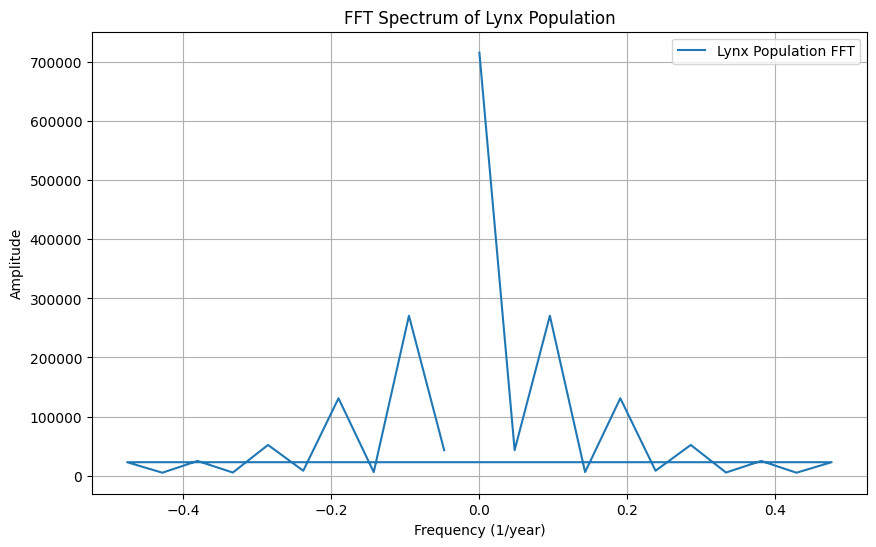

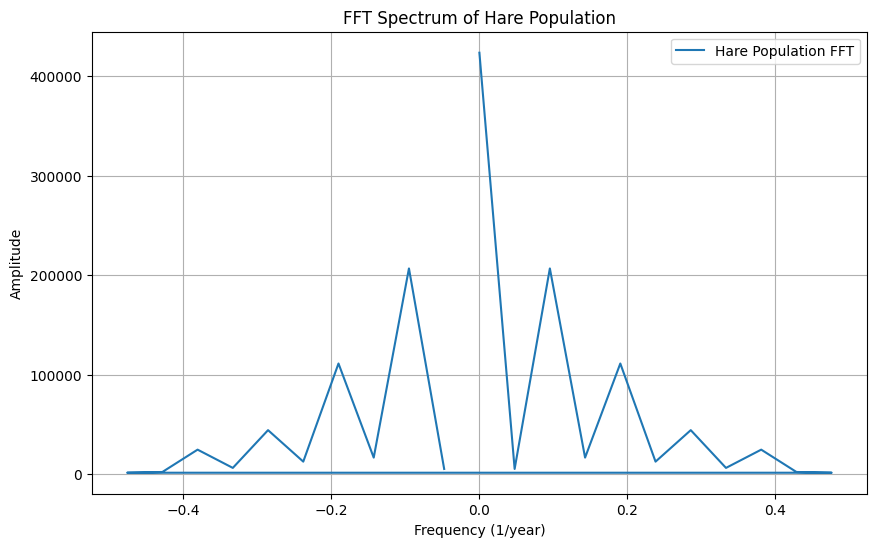

In [5]:
lynx_fft = np.fft.fft(lynx_population)
hare_fft = np.fft.fft(hare_population)

# Calculate the frequencies corresponding to the FFT components
dt = years[1] - years[0]  # Time step
N = len(years)            # Number of data points
freq = np.fft.fftfreq(N, dt)

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(lynx_fft), label='Lynx Population FFT')
plt.xlabel('Frequency (1/year)');plt.ylabel('Amplitude');plt.title('FFT Spectrum of Lynx Population')
plt.grid(True);plt.legend();plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(hare_fft), label='Hare Population FFT')
plt.xlabel('Frequency (1/year)');plt.ylabel('Amplitude');plt.title('FFT Spectrum of Hare Population')
plt.grid(True);plt.legend();plt.show()


In [6]:
# Find the dominant frequency for lynxes
lynx_peak_freq = freq[np.argmax(np.abs(lynx_fft))]
lynx_period = 1 / lynx_peak_freq

# Find the dominant frequency for hares
hare_peak_freq = freq[np.argmax(np.abs(hare_fft))]
hare_period = 1 / hare_peak_freq

print("Dominant frequency (Lynxes):", lynx_peak_freq)
print("Period (Lynxes):", lynx_period)

print("Dominant frequency (Hares):", hare_peak_freq)
print("Period (Hares):", hare_period)
#This may be due to insufficient variability in the data to distinguish periodic behavior, insufficient number of data, empty space 
#in the graph, or aperiodic behavior of populations.

Dominant frequency (Lynxes): 0.0
Period (Lynxes): inf
Dominant frequency (Hares): 0.0
Period (Hares): inf


C:\Users\oguzh\AppData\Local\Temp\ipykernel_12284\739529493.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  lynx_period = 1 / lynx_peak_freq
C:\Users\oguzh\AppData\Local\Temp\ipykernel_12284\739529493.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  hare_period = 1 / hare_peak_freq


4. FFT of an image

Write a filter that removes the periodic noise from the moonlanding.png image by using a 2-dimensional FFT.

-Import the image as a 2D numpy array using plt.imread("images/moonlanding.png"). Examine the image with plt.imshow(), which is heavily contaminated with periodic no
ise.
-Check the documentation of the scipy.fftpack package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. Hint: use LogNorm to plot the colors in log s
cale:
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(v
min=5))
-Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions 
to zero.
-Apply the inverse Fourier transform to plot the resulting image.

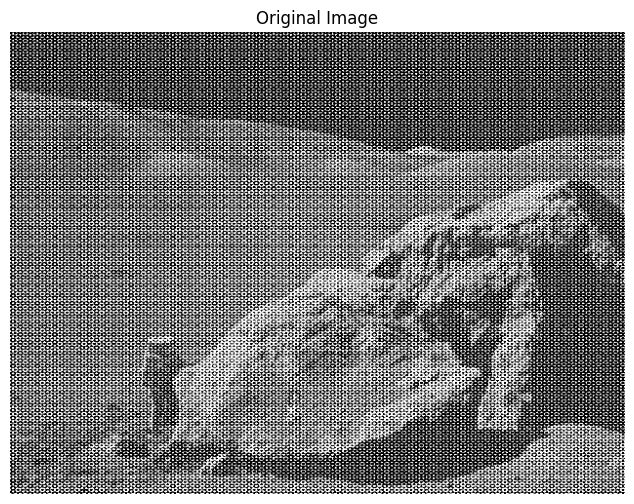

In [7]:
from scipy.fft import fft2, ifft2
from matplotlib.colors import LogNorm
from scipy import fftpack
import matplotlib.pyplot as pylab
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter, uniform_filter

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar(label='Magnitude')

image = plt.imread("images/moonlanding.png")

plt.figure(figsize=(8, 6));plt.imshow(image, cmap='gray');plt.title('Original Image');plt.axis('off');plt.show()


Text(0.5, 1.0, 'Reconstructed Image')

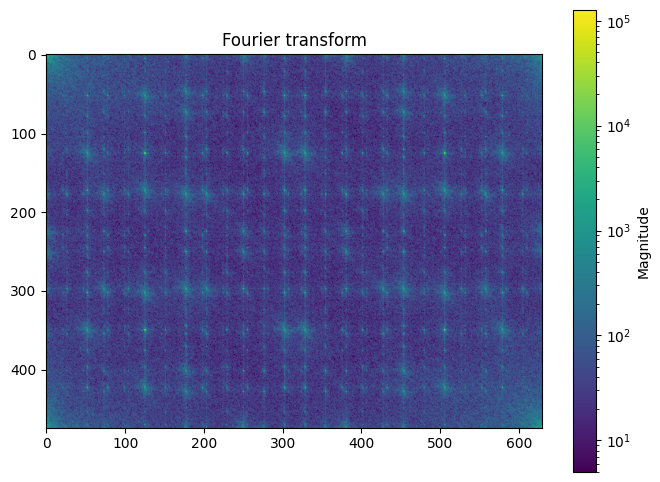

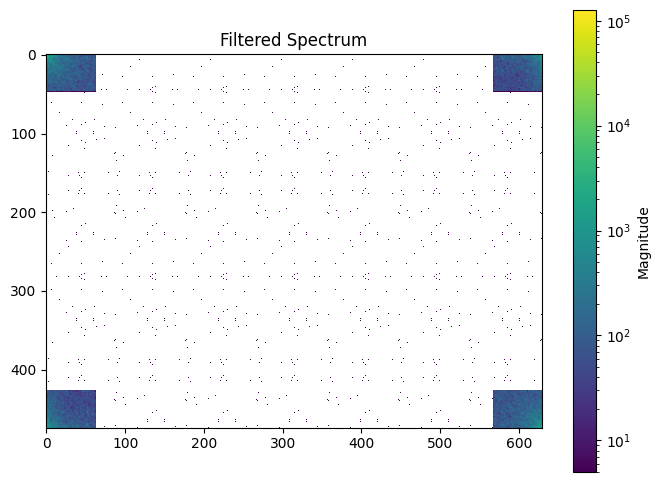

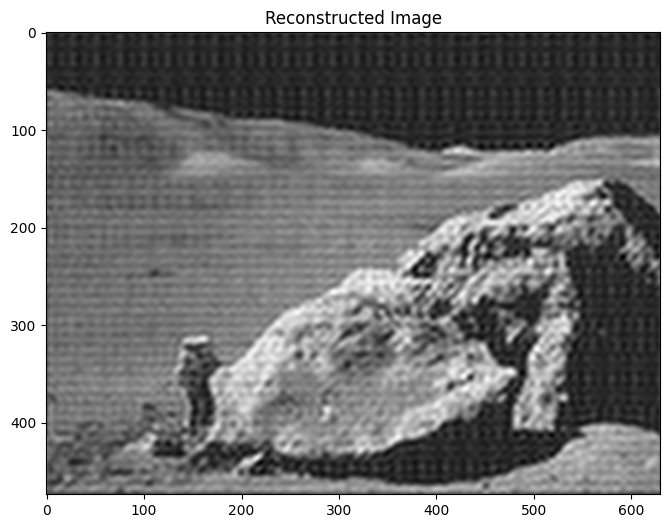

In [8]:
im_fft = fftpack.fft2(image)
plt.figure(figsize=(8, 6));plot_spectrum(im_fft);plt.title('Fourier transform')

# In the lines following, we'll make a copy of the original spectrum and truncate coefficients.

keep_fraction = 0.1  # fraction of coefficients (in each direction) we keep

im_fft2 = im_fft.copy()

r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
plt.figure(figsize=(8, 6));plot_spectrum(im_fft2);plt.title('Filtered Spectrum')

im_new = fftpack.ifft2(im_fft2).real
plt.figure(figsize=(8, 6));plt.imshow(im_new, plt.cm.gray);plt.title('Reconstructed Image')

# Peaks around higher frequencies correspond to the periodic noise.
# From the photo, we can see that the noise (measurement artifacts) is highly periodic.

In [9]:
# The image with those peaks suppressed indeed

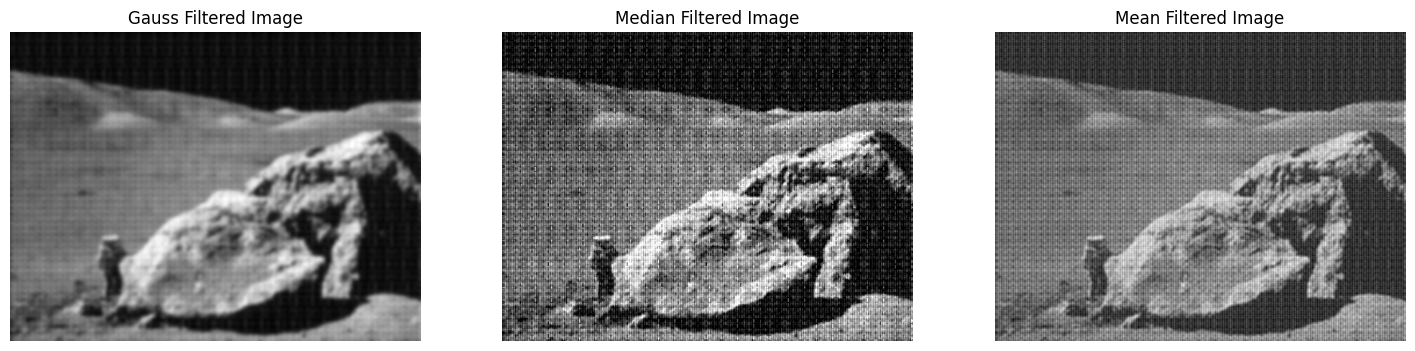

In [10]:
filtered_image = gaussian_filter(image, sigma=3)
median_filtered_image = median_filter(image, size=5)
mean_filtered_image = uniform_filter(image, size=5)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1);plt.imshow(filtered_image, cmap='gray');plt.title('Gauss Filtered Image');plt.axis('off')
plt.subplot(1, 3, 2);plt.imshow(median_filtered_image, cmap='gray');plt.title('Median Filtered Image');plt.axis('off')
plt.subplot(1, 3, 3);plt.imshow(mean_filtered_image, cmap='gray');plt.title('Mean Filtered Image');plt.axis('off')
plt.show()
